## Visualize the signature application to other clone data

In `9.apply-signature-otherclones.ipynb`, I acquired bortezomib resistance signature scores.
Here, I visualize them.

In [22]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(gridExtra))

source(file.path("utils", "viz.R"))

In [23]:
seed <- 1234
set.seed(seed)

In [24]:
# Set constants
dataset <- "otherclones"
sig_dir <- file.path("results", "singscore")
perf_dir <- file.path("results", "performance")

sig_results_file <- file.path(sig_dir, paste0("singscore_results_", dataset, ".tsv.gz"))
roc_auc_file <- file.path(perf_dir, paste0(dataset, "_bortezomibsignature_roc_auc.tsv"))
roc_curve_file <- file.path(perf_dir, paste0(dataset, "_bortezomibsignature_roc_curve.tsv"))

output_figure_dir <- file.path("figures", "singscore")

In [25]:
# Load signature scores
# Load raw signature results
sig_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

inference_df <- readr::read_tsv(sig_results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split == "inference")

signature_df <- readr::read_tsv(sig_results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split != "inference")

print(dim(signature_df))
head(signature_df, 4)

[1] 420  28


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
218698,B02,2020_08_24_Batch9,12640,5x10^3 cells/well,1,WT_parental,20200818,218698,48 hr,⋯,-0.05648804,381.7695,-0.07124256,215.7183,0.01475452,166.0512,0.702,otherclones,-0.1557863,0.1568304
218698,B03,2020_08_24_Batch9,8927,5x10^3 cells/well,2,WT clone 04,20200818,218698,48 hr,⋯,0.01066693,707.2002,0.03311012,391.4064,-0.02244319,315.7938,0.487,otherclones,-0.1557863,0.1568304
218698,B04,2020_08_24_Batch9,6044,5x10^3 cells/well,3,WT clone 05,20200818,218698,48 hr,⋯,0.10173934,488.5167,0.11597842,239.4399,-0.01423908,249.0768,0.145,otherclones,-0.1557863,0.1568304
218698,B05,2020_08_24_Batch9,7530,5x10^3 cells/well,4,WT clone 06,20200818,218698,48 hr,⋯,0.34652286,320.9829,0.18452381,199.4097,0.16199906,121.5732,0.001,otherclones,-0.1557863,0.1568304


In [26]:
# Load performance metrics info
metric_levels <- c("dataset")
shuffle_levels <- c("", "shuffle")

performance_data <- list()
for (metric_level in metric_levels) {
    performance_data[[metric_level]] <- list()
    for (shuffle_level in shuffle_levels) {
        if (shuffle_level == "shuffle") {
            shuffle_id <- "_shuffle"
        } else {
            shuffle_id <- ""
        }
        
        # Note I set file name here
        input_file <- paste0(metric_level, "_otherclones", shuffle_id, "_metric_performance.tsv")
        input_file <- file.path(perf_dir, input_file)
        
        performance_data[[metric_level]][[shuffle_level]] <-
            readr::read_tsv(input_file, col_types = readr::cols())
    }
}

# Load ROC info
roc_curve_cols <- readr::cols(
    fpr = readr::col_double(),
    tpr = readr::col_double(),
    threshold = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_curve_df <- readr::read_tsv(roc_curve_file, col_types=roc_curve_cols)

roc_cols <- readr::cols(
    roc_auc = readr::col_double(),
    model_split = readr::col_character(),
    shuffled = readr::col_character()
)

roc_df <- readr::read_tsv(roc_auc_file, col_types=roc_cols) %>%
    dplyr::arrange(shuffled) %>%
    dplyr::mutate(roc_auc = round(roc_auc, 3))

roc_df <- roc_df[, c("model_split", "shuffled", "roc_auc")]
colnames(roc_df) <- c("Split", "AUROC\nShuffled:", "roc_auc")

roc_df <- roc_df %>%
    tidyr::spread(`AUROC\nShuffled:`, roc_auc, sep="") %>%
    dplyr::arrange(desc(Split))

roc_df$Split <- dplyr::recode(roc_df$Split, !!!legend_labels)
roc_df

Split,AUROC Shuffled:False,AUROC Shuffled:True
<chr>,<dbl>,<dbl>
ixazomib,0.628,0.506
cb5083,0.592,0.567


In [27]:
table_theme <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.3)),
    colhead = list(fg_params=list(cex = 0.3)),
    padding = unit(c(1.5, 1.5), "mm")
)

table_gg <- gridExtra::tableGrob(roc_df,
                                 theme = table_theme,
                                 rows = NULL)

In [28]:
threshold_points_df <- roc_curve_df %>%
    dplyr::filter(shuffled == "False") %>%
    dplyr::group_by(model_split) %>%
    dplyr::filter(abs(threshold) == min(abs(threshold))) %>%
    dplyr::ungroup()

legend_colors <- c("cb5083" = "#1A85FF", "ixazomib" = "#D41159")
legend_labels <- c("cb5083" = "CB-5083", "ixazomib" = "Ixazomib")

roc_gg <- (
    ggplot(roc_curve_df, aes(x = fpr, y = tpr))
    + geom_line(aes(color = model_split, linetype = shuffled), size=0.2)
    + geom_point(data = threshold_points_df, aes(color = model_split), size = 1)
    + geom_abline(intercept=0, slope=1, size=0.2, linetype="dashed", color="black")
    + scale_color_manual(name="Dataset", labels=legend_labels, values=legend_colors)
    + scale_linetype_manual(name="Shuffled", labels=linetype_labels, values=linetype_default)
    + coord_fixed()
    + xlab("False positive rate")
    + ylab("True positive rate")
    + annotation_custom(table_gg, ymin = -0.82, xmin = 0.42)
    + custom_theme
    + theme(legend.position = "bottom")
    + guides(col = guide_legend(nrow = 2, byrow = TRUE), linetype = guide_legend(nrow = 2, byrow = TRUE))
)

In [29]:
min_val <- unique(signature_df$min_permuted_value)
max_val <- unique(signature_df$max_permuted_value)

In [30]:
summary_box_plot = (
    ggplot(
        signature_df,
        aes(x=Metadata_dataset, y=TotalScore)
    )
    + geom_boxplot(aes(fill = Metadata_clone_type), lwd = 0.1, alpha = 0.9, outlier.alpha = 0)
    + geom_jitter(
        position = position_jitterdodge(jitter.width = 0.4, dodge.width = 0.75),
        aes(fill = Metadata_clone_type),
        stroke = 0.2,
        alpha = 0.6,
        shape = 21,
        lwd = 0.5
    )
    + geom_hline(yintercept = 0, linetype = "dashed", size = 0.2, color = "black")
    + annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0.5,
         xmax = 2.5,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         size = 0.1
    )
    + scale_fill_manual("Resistance status", values = resistance_status_colors, labels = resistance_status_labels)
    + xlab("Resistance to which compound")
    + ylab("Signature score\n(singscore)")
    + custom_theme
)

In [31]:
box_plot_gg <- (
    ggplot(signature_df, aes(x = Metadata_clone_number, y = TotalScore))
    + geom_boxplot(aes(fill = Metadata_clone_type), lwd = 0.1, alpha = 0.9, outlier.alpha = 0)
    + geom_jitter(
        position = position_jitterdodge(jitter.width = 0.4, dodge.width = 0.75),
        aes(fill = Metadata_clone_type),
        stroke = 0.2,
        alpha = 0.6,
        shape = 21,
        lwd = 0.5
    )
    + facet_wrap(
        "~Metadata_dataset",
        ncol = 1,
        scales = "free_y"
    )
    + xlab("")
    + ylab("Signature score\n(singscore)")
    + scale_fill_manual("Resistance status", values = resistance_status_colors, labels = resistance_status_labels)
    + scale_y_continuous(breaks = c(-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6), minor_breaks = seq(-10, 10, 0.1))
    + geom_hline(yintercept = 0, linetype = "dashed", size = 0.2, color = "black")
    + coord_flip()
    + annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0.3,
         xmax = 11,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         size = 0.1
    )
    + custom_theme
    + guides(fill = guide_legend(reverse = TRUE))
)

In [32]:
random_perm_legend <- (
    ggplot(
        signature_df %>% dplyr::mutate(label="grey"),
        aes(x=Metadata_clone_number, y = TotalScore, color = label)
    )
    + geom_line(linetype = "dashed", lwd = 0.1)
    + scale_color_manual(
        name = "",
        values = "red",
        labels = "95% CI\n1000 random\npermutations"
    )
    + custom_theme
    + theme(legend.key = element_rect(fill = alpha("grey", 0.2)))
)

random_perm_legend <- cowplot::get_legend(random_perm_legend)

boxplot_legend <- cowplot::plot_grid(
    cowplot::ggdraw(),
    cowplot::get_legend(box_plot_gg),
    cowplot::ggdraw(),
    random_perm_legend,
    cowplot::ggdraw(),
    nrow = 5,
    rel_heights = c(0.7, 0.35, 0.01, 0.35, 1),
    align = "hv",
    axis = "l"
)

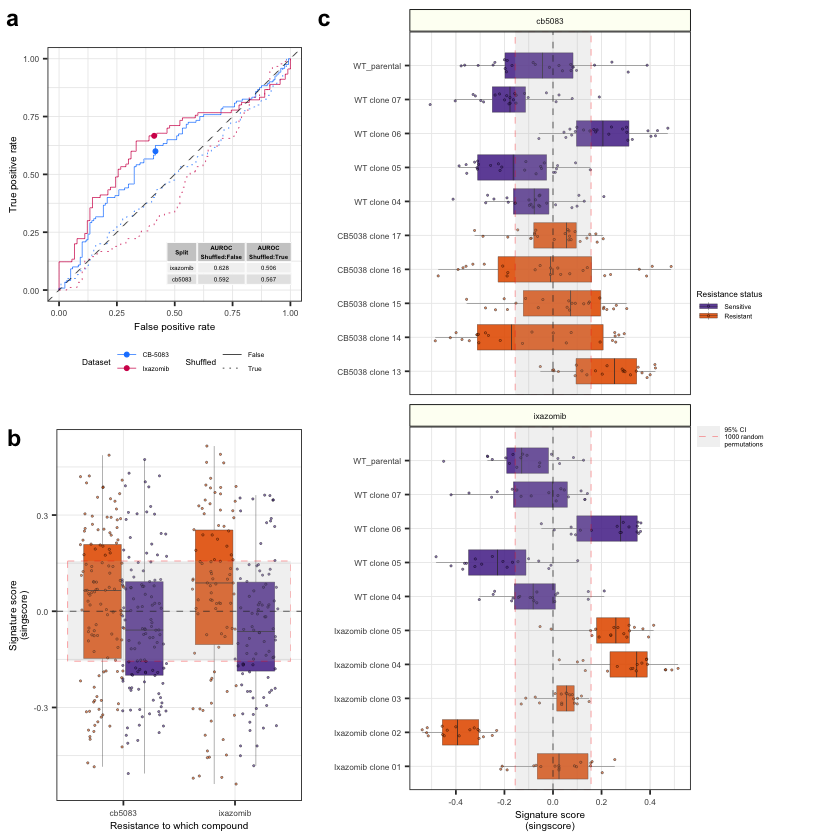

In [34]:
other_clone_figure_gg <- cowplot::plot_grid(
    cowplot::plot_grid(
        cowplot::plot_grid(
            roc_gg,
            summary_box_plot + theme(legend.position = "none"),
            labels = c("a", "b"),
            ncol = 1
            ),
        box_plot_gg + theme(legend.position = "none"),
        labels = c("", "c"),
        rel_widths = c(0.8, 1)
    ),
    boxplot_legend,
    ncol = 2,
    align = "hv",
    axis = "l",
    rel_widths = c(1, 0.2),
    labels = c("", "")
)

output_fig_file <- file.path("figures", "otherclone_bortezomib_signature_scores.png")
ggsave(output_fig_file, other_clone_figure_gg, dpi = 500, height = 6, width = 7)

other_clone_figure_gg